## Upload files

In [ ]:
#download kaggle api (kaggle.json) and import it here
from google.colab import files
files.upload()

In [ ]:
pip install -q tensorflow tensorflow-datasets

In [ ]:
pip install mlflow

## Import Libraries

In [11]:
pip show tensorflow_datasets

Name: tensorflow-datasets
Version: 4.4.0
Summary: tensorflow/datasets is a library of datasets ready to use with TensorFlow.
Home-page: https://github.com/tensorflow/datasets
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/paulosgidyelew/Desktop/cassava-classification-capstone/.venv/lib/python3.9/site-packages
Requires: absl-py, attrs, dill, future, numpy, promise, protobuf, requests, six, tensorflow-metadata, termcolor, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, InputLayer, Dense, Dropout, BatchNormalization, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import mlflow
from keras import backend as K
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, fbeta_score
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Accuracy, Recall

import itertools,cv2,os, sys 
sys.path.append(os.path.dirname(os.path.realpath('/Users/paulosgidyelew/Desktop/cassava-classification-capstone/src')))
import random
from shutil import copyfile
import shutil
import random 

# mlflow parameters:
EXPERIMENT_NAME = "Classava_capstone"
TRACKING_URI = "https://hudsju377cddpoevnjdkfnvpwovniewnipcdsnkvn.mlflow.neuefische.de"

warnings.filterwarnings('ignore')

import numpy as np
import tensorflow_datasets as tfds
RSEED = 42
tf.random.set_seed(RSEED)

/Users/paulosgidyelew/Desktop/cassava-classification-capstone/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Following is a function that we will use in the notebook to plot a confusion matrix

## Loading the dataset

We will download the data from the kaggle website using the kaggle API. You need an account on kaggle to do this step. 

In [2]:
#download kaggle api (kaggle.json) and import it here
#from google.colab import files
#files.upload()

We have to create a directory for the Kaggle API

In [ ]:
# 600 permissions: only the owner has full read and write access to the API key (chmod=change mode)

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Now let us download the data and unzip it

In [ ]:
#!kaggle competitions download -c cassava-leaf-disease-classification -p /content/ -f train.csv

In [ ]:
!kaggle competitions download -c cassava-disease -f train.zip
!kaggle competitions download -c cassava-disease -f test.zip


100% 775M/777M [00:13<00:00, 45.7MB/s]
100% 777M/777M [00:14<00:00, 58.0MB/s]
100% 514M/515M [00:15<00:00, 26.5MB/s]
100% 515M/515M [00:15<00:00, 33.9MB/s]


In [ ]:
!unzip train.zip > /dev/null
!unzip test.zip > /dev/null

We are also provided with the csv file that we have already seen in the EDA:

In [ ]:
#data = pd.read_csv('train.csv')
#data.head()

## Oversampling

In [4]:
os.listdir('../data/train')

['cgm', 'cmd', 'healthy', 'cbb', 'cbsd']

Let's check which class in our dataset is the biggest

In [2]:
class_amount_list = []
for i in os.listdir('../data/train'):
  
  if i in ['cbb','cbsd','cgm','cmd','healthy']:
    
    class_amount_list.append(len(os.listdir('../data/train/'+i)))
   
  else:
    continue

#biggest_class is the amount of images that the biggest class has
biggest_class = np.max(class_amount_list)

Let' create copies of random images in the folders that have less images than the biggest class, until all the classes have the same amount of images.

In [ ]:
#count how many files are in folder
dirlist = os.listdir('../data/train')
for i in dirlist:
  len_class = len(os.listdir('../data/train/'+i))
  counter=0
  if len_class == biggest_class:
    continue
  combined_len = 0
  while (combined_len<=biggest_class):
    select_file = random.choice(os.listdir('../data/train/' + i))
    filepath = '../data/train/' + i + '/' + select_file

    filepath_copy = filepath.split('.')
   
    filepath_path = filepath_copy[0].split('/')
    filepath_path[1] = filepath_path[1] + '_copy'
    filepath_copy[0] = filepath_path[0] + '/' + filepath_path[1] + '/' + filepath_path[2] + '_copy_' + str(counter)
    filepath_copy = str(filepath_copy[0]) + '.' + str(filepath_copy[1])
    if os.path.isdir('../data/train/'+i+'_copy') == False:
      os.mkdir ('../data/train/'+i+'_copy')
    copyfile(filepath,filepath_copy)
    len_class = len(os.listdir('../data/train/'+i))
    len_class_copy = len(os.listdir('../data/train/'+i+'_copy'))
    combined_len = len_class + len_class_copy
    counter+=1

Now lets move the dublicated files to the original folder and then delete the empty folders that were holding the copies.

In [ ]:
for i in dirlist:
  if os.path.isdir('train/' + i + '_copy') == False:
    continue
  files = os.listdir('train/' + i + '_copy')
  for element in files:
    shutil.move('train/' + i + '_copy/' + element, 'train/' + i + '/' + element)

In [ ]:
for i in dirlist:
  if os.path.isdir('train/' + i + '_copy') == False:
    continue
  os.rmdir('train/' + i + '_copy')

Let's check the reults

In [ ]:
class_amount_list2 = []
for i in os.listdir('train'):
  class_amount_list2.append(len(os.listdir('train/'+i)))

class_amount_list2

[2659, 2659, 2658, 2659, 2659]

Perfect. Now that the oversampling worked we will continue with the modeling part.

## Cassava-specific pre-trained model + less dropout

The pre-trained model gave us an accuracy of 0.63. The pre-trained model was trained on various images. Now we want to use a pre-trained model that was trained on cassava leaves. This model can be found here: It can be found here: <a href="https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1">https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1</a>

Let us set up MlFlow in order to track our parameters and results. 

In [ ]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run(run_name='pre-trained model cassava-specific')
run = mlflow.active_run()

Now we will initialize the model and create its architecture. Afterwards the model gets compiled and is run. The process is stored in the history.

In [ ]:
TFL_HUB_HANDLE = 'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1'

model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(hub.KerasLayer(TFL_HUB_HANDLE,trainable=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,'softmax')) 

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4234118   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 4,322,507
Trainable params: 88,389
Non-tra

The input images should be of the size 224x224. Therefore, we have to create the input data again, using the ImageDataGenerator

In [ ]:
image_data_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90, 
                                          shear_range=0.2, 
                                          zoom_range=0.2, 
                                          horizontal_flip=True, 
                                          vertical_flip=True,
                                          validation_split=0.2
                                          )
train_set = image_data_generator.flow_from_directory('/content/train', 
                                                     subset='training', 
                                                     target_size=(224,224), 
                                                     class_mode='categorical', 
                                                     batch_size=32, 
                                                     shuffle=True,
                                                     interpolation='nearest',
                                                     color_mode="rgb",
                                                     )
val_set = image_data_generator.flow_from_directory('/content/train', 
                                                   subset='validation', 
                                                   target_size=(224,224), 
                                                   class_mode='categorical', 
                                                   batch_size=32, 
                                                   shuffle=False,
                                                   interpolation='nearest',  
                                                   color_mode="rgb"
                                                   )

Found 10639 images belonging to 5 classes.
Found 2655 images belonging to 5 classes.


In [ ]:
model_checkpoint_filepath = 'pre-trained_cassava-less-dropout3.ckpt'
model_check_point = ModelCheckpoint(model_checkpoint_filepath,
                                    verbose=1, 
                                    save_weights_only=True, 
                                    monitor='val_loss', 
                                    save_best_only=True, 
                                    mode='auto'
                                    )
history = model.fit(train_set,
                    epochs=10,
                    verbose=1,
                    callbacks=[model_check_point],
                    validation_data=val_set, 
                    steps_per_epoch=len(train_set),
                    validation_steps=len(val_set)
                    )

Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 0.7189 - accuracy: 0.7534
Epoch 00001: val_loss improved from inf to 0.47653, saving model to pre-trained_cassava-less-dropout3.ckpt
333/333 [==============================] - 341s 1s/step - loss: 0.7189 - accuracy: 0.7534 - val_loss: 0.4765 - val_accuracy: 0.8486
Epoch 2/10
333/333 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.8266
Epoch 00002: val_loss improved from 0.47653 to 0.46890, saving model to pre-trained_cassava-less-dropout3.ckpt
333/333 [==============================] - 334s 1s/step - loss: 0.5575 - accuracy: 0.8266 - val_loss: 0.4689 - val_accuracy: 0.8463
Epoch 3/10
333/333 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.8307
Epoch 00003: val_loss improved from 0.46890 to 0.46448, saving model to pre-trained_cassava-less-dropout3.ckpt
333/333 [==============================] - 335s 1s/step - loss: 0.5308 - accuracy: 0.8307 - val_loss: 0.4645 - val_accu

We reached an accuracy of 0.8742 and a loss of 0.3801. Validation: acc: 0.8407, loss: 0.4985


If we saved the model before, we don't have to calculate is again. Instead, we can just load is from our Drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model = tf.keras.models.load_model('/content/drive/MyDrive/final_models/best_model_with_oversampling')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's create a folder in our google drive and then save the model there. 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir -p /content/drive/MyDrive/final_models
# model.save('/content/drive/MyDrive/final_models/best_model_with_oversampling')

Mounted at /content/drive
INFO:tensorflow:Assets written to: /content/drive/MyDrive/final_models/best_model_with_oversampling/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/final_models/best_model_with_oversampling/assets


Let us plot the training progress:

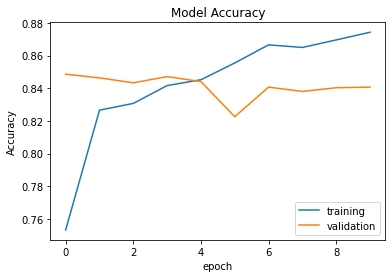

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['training','validation'], loc='lower right')
plt.show()

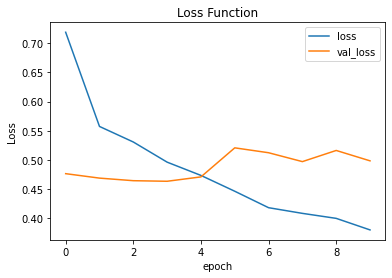

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Function')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.show()

### Construction of the confusion matrix

In [ ]:
#we can use model.predict to predict the validation set and argmax gives us the the highest number for each element
results = model.predict(val_set)
results = np.argmax(results, axis=1)

In [ ]:
#report = classification_report(list_of_true_labels,results)
report = classification_report(val_set.classes,results)
print (report)

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       531
           1       0.78      0.81      0.80       531
           2       0.86      0.81      0.83       531
           3       0.85      0.91      0.88       531
           4       0.86      0.89      0.87       531

    accuracy                           0.84      2655
   macro avg       0.84      0.84      0.84      2655
weighted avg       0.84      0.84      0.84      2655



Confusion matrix, without normalization


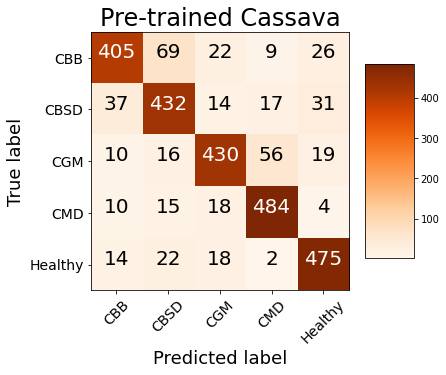

In [ ]:
cm = confusion_matrix(val_set.classes,results)
confusion_matrix.plot_confusion_matrix(
    cm, classes=['CBB', 'CBSD','CGM','CMD','Healthy'], 
    title='Pre-trained Cassava'
)

Heathy has a very low precision. This is actually not good, because here we have many instances that were categorized as healthy although they are sick. These plants would not get destroyed and could contirbute to a food crisis if the disease continues to spread. 

Calculation of the F2 score (description can be found in the simple model chapter)

In [ ]:
#Due to imbalance in our dataset we have to use 'macro' for averaging
F2_score = fbeta_score(val_set.classes,results, average='macro', beta=2)
print(F2_score)

0.8379277292208542


The overall F2 score is 0.8379277292208542

The F2 score for healthy is:

In [ ]:
#F2_healthy = (5 * Precision * Recall) / (4 * Precision + Recall)
F2_healthy = (5 * 0.86 * 0.89) / (4 * 0.86 + 0.89)
F2_healthy

0.8838337182448037

The F2 score for healthy is 0.883

Lets collect parameters and then save them to MLflow. 

In [ ]:
#These are the parameters that will be transfered to MlFlow for logging our experiments

#Find meaningful parameters!
params = {
            "number of epochs": 10,
            "input_shape": val_set[0][0][0].shape,
            "confusion matrix":cm
        }

In [ ]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("colab", "True")
#logging metrics
mlflow.log_metric("train-" + "accuracy", history.history['accuracy'][-1])
mlflow.log_metric("val-" + "accuracy", history.history['val_accuracy'][-1])
mlflow.log_metric("train-" + "loss", history.history['loss'][-1])
mlflow.log_metric("val-" + "loss", history.history['val_loss'][-1])
mlflow.log_metric("F2-score", F2_score)

# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

# Error Analysis

#### Now let us create a dataframe that holds the misclassified files and systematically examine prediction errors. 

In [ ]:
df = pd.DataFrame()
df['filename'] = val_set.filenames
df['true_values'] = val_set.classes
df['pred_values'] = results.astype(np.int32)
df.sample(5)

,filename,true_values,pred_values
916,cbsd/train-cbsd-1192.jpg,1,1
512,cbb/train-cbb-185_copy_748.jpg,0,0
1,cbb/train-cbb-0_copy_1930.jpg,0,0
389,cbb/train-cbb-164_copy_1452.jpg,0,0
783,cbsd/train-cbsd-1125.jpg,1,1


In [ ]:
err_data = df.query('true_values != pred_values')
corr_data = df.query('true_values == pred_values')
err_data.sample(5)

,filename,true_values,pred_values
1419,cgm/train-cgm-194_copy_1871.jpg,2,3
1370,cgm/train-cgm-18.jpg,2,3
871,cbsd/train-cbsd-1168.jpg,1,0
168,cbb/train-cbb-127_copy_1802.jpg,0,1
679,cbsd/train-cbsd-1072.jpg,1,0


In [ ]:
labels_dict = {
                0:'cbb',
                1:'cbsd',
                2:'cgm',
                3:'cmd',
                4:'healthy'
                }

In [ ]:
err_data['pred_name'] = err_data.pred_values.map(labels_dict)
err_data['true_name'] = err_data.true_values.map(labels_dict)
corr_data['pred_name'] = corr_data.pred_values.map(labels_dict)
corr_data['true_name'] = corr_data.true_values.map(labels_dict)

In [ ]:
err_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429 entries, 10 to 2617
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     429 non-null    object
 1   true_values  429 non-null    int32 
 2   pred_values  429 non-null    int32 
 3   pred_name    429 non-null    object
 4   true_name    429 non-null    object
dtypes: int32(2), object(3)
memory usage: 16.8+ KB


In [ ]:
err_data.true_name.value_counts()

cbb        126
cgm        101
cbsd        99
healthy     56
cmd         47
Name: true_name, dtype: int64

In [ ]:
corr_data.true_name.value_counts()

cmd        484
healthy    475
cbsd       432
cgm        430
cbb        405
Name: true_name, dtype: int64

# Overall Classification Error (${\epsilon}$):

As we can see below, the overall classifcation error is about 13%
Hence, we need at least 100/${\epsilon}$ validation set, which is about: 769 

In [ ]:
error = np.divide(err_data.shape[0],val_set.classes.shape[0])
print(f'Overall Classification Error (\u03B5): {error.round(2)}')

Overall Classification Error (ε): 0.16


# Error counts:
  <ol> 
    <li>cbsd accounts for 33.6%</li>
    <li>cgm accounts for 25.5%</li> 
    <li> cbb accounts for 18.8%</li>
    <li> cmd accounts for 15.4%</li> 
    <li> healthy accounts for 6.7%</li>
  </ol>

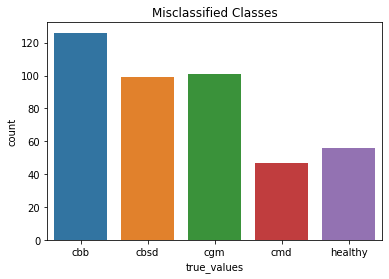

In [ ]:
import seaborn as sns

sns.countplot(data=err_data,x= err_data.true_values)
plt.xticks([0,1,2,3,4], ['cbb','cbsd','cgm','cmd','healthy'])
plt.title('Misclassified Classes')
plt.show()

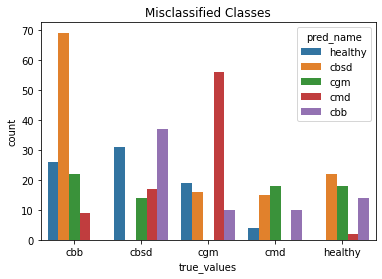

In [ ]:
sns.countplot(data=err_data,x= err_data.true_values, hue=err_data.pred_name)
plt.xticks([0,1,2,3,4], ['cbb','cbsd','cgm','cmd','healthy'])
plt.title('Misclassified Classes')
plt.show()

\ From the above diagram we can see that class-cbsd is the highest misclassified class, thus our focus will be this class. Eventhough cmd has lower misclassification distribution, due to its contiguousness it will be considered as area of focus. 

In [ ]:
wrongly_healthy = err_data.query('pred_values==4')
wrongly_healthy.reset_index(drop=True, inplace=True )
correct_healthy = corr_data.query('pred_values==4')
correct_healthy.reset_index(drop=True, inplace=True )

In [ ]:
wrongly_healthy.head(8)

,filename,true_values,pred_values,pred_name,true_name
0,cbb/train-cbb-101.jpg,0,4,healthy,cbb
1,cbb/train-cbb-109.jpg,0,4,healthy,cbb
2,cbb/train-cbb-109_copy_1934.jpg,0,4,healthy,cbb
3,cbb/train-cbb-10_copy_607.jpg,0,4,healthy,cbb
4,cbb/train-cbb-10_copy_617.jpg,0,4,healthy,cbb
5,cbb/train-cbb-115.jpg,0,4,healthy,cbb
6,cbb/train-cbb-115_copy_642.jpg,0,4,healthy,cbb
7,cbb/train-cbb-11_copy_799.jpg,0,4,healthy,cbb


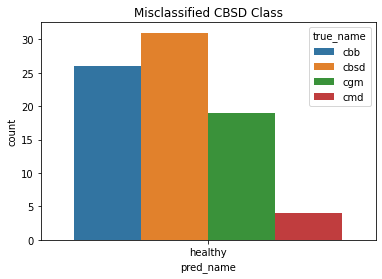

In [ ]:
sns.countplot(data=wrongly_healthy,x= wrongly_healthy.pred_name, hue=wrongly_healthy.true_name)
plt.title('Misclassified CBSD Class')
plt.show()

In [ ]:
# cbsd = err_data.query('true_values==1')
# cbsd.reset_index(drop=True, inplace=True )
# cbsd_corr = corr_data.query('true_values==1')
# cbsd_corr.reset_index(drop=True, inplace=True )

In [ ]:
# sns.countplot(data=cbsd,x= cbsd.true_values, hue=cbsd.pred_name)
# plt.xticks([0,1,2,3,4], ['cbb','cbsd','cgm','cmd','healthy'])
# plt.title('Misclassified CBSD Class')
# plt.show()

# Hypothesis formation:
$H_{0}:$ 
          
          1. mislabeled images
          2. image shape
          3. image color
          4. blurriness
          5. image zoom-factor
would be the main contributers to the misclassification

In [ ]:
wrongly_healthy2 = wrongly_healthy.copy()
correct_healthy2 = correct_healthy.copy()

In [ ]:
# import random 
# cbsd_misclasified = cbsd.copy()
# cbsd_corr_clasified = cbsd_corr.copy()

In [ ]:
wrongly_healthy

,filename,true_values,pred_values,pred_name,true_name
0,cbb/train-cbb-101.jpg,0,4,healthy,cbb
1,cbb/train-cbb-109.jpg,0,4,healthy,cbb
2,cbb/train-cbb-109_copy_1934.jpg,0,4,healthy,cbb
3,cbb/train-cbb-10_copy_607.jpg,0,4,healthy,cbb
4,cbb/train-cbb-10_copy_617.jpg,0,4,healthy,cbb
...,...,...,...,...,...
75,cgm/train-cgm-22_copy_708.jpg,2,4,healthy,cgm
76,cmd/train-cmd-1029.jpg,3,4,healthy,cmd
77,cmd/train-cmd-1114.jpg,3,4,healthy,cmd
78,cmd/train-cmd-1253.jpg,3,4,healthy,cmd


In [ ]:
wrongly_healthy_labels = [labels_dict[label] for label in wrongly_healthy2.pred_values]
correct_healthy_labels = [labels_dict[label] for label in correct_healthy2.pred_values]

#cbsd_pred_labels = random.choices(cbsd_pred_labels,k=100)

In [ ]:
wrongly_healthy_filename = list(wrongly_healthy.filename)
correct_healthy_filename = list(correct_healthy.filename)

Lets check out how many images we have, that have not been  copied during oversampling.

In [ ]:
no_copy_wrong = []
for i in wrongly_healthy_filename:
  if 'copy' not in i:
    no_copy_wrong.append(i)

In [ ]:
no_copy_correct = []
for i in correct_healthy_filename:
  if 'copy' not in i:
    no_copy_correct.append(i)

Lets copy the wrongly and correctly classified images to folders and download them. 

In [ ]:
!mkdir -p /content/wrongly_healthy
!mkdir -p /content/correct_healthy

In [ ]:
for i in no_copy_wrong:
  copyfile('train/' + i, 'wrongly_healthy/' + i.split('/')[1])
for i in no_copy_correct:
  copyfile('train/' + i, 'correct_healthy/' + i.split('/')[1])

In [ ]:
!zip -r /content/wrongly_healthy.zip /content/wrongly_healthy
!zip -r /content/correct_healthy.zip /content/correct_healthy

## Analysis of blurriness:

In [ ]:
df = pd.DataFrame()
df['filename'] = val_set.filenames
df['true_values'] = val_set.classes
df['pred_values'] = results
df.head(5)

,filename,true_values,pred_values
0,cbb/train-cbb-0.jpg,0,0
1,cbb/train-cbb-0_copy_1058.jpg,0,0
2,cbb/train-cbb-0_copy_1519.jpg,0,0
3,cbb/train-cbb-0_copy_362.jpg,0,0
4,cbb/train-cbb-0_copy_383.jpg,0,0


In [ ]:
misclassified = df.query('true_values != pred_values').filename
corr_classified = df.query('true_values == pred_values').filename

misclassified = list(misclassified)
corr_classified = list(corr_classified)

In [ ]:
# figure, axes = plt.subplots(int(np.ceil(len(misclassified)/3)), 3, figsize=(15, 250),sharey=True, sharex=True)
# axes = axes.ravel()
# for idx, i in enumerate(misclassified):
#   filepath = 'train/' + i
#   img = cv2.imread(filepath)
#   axes[idx].imshow(img)
#   axes[idx].title.set_text(i.split('/')[0])
# plt.show()

In [ ]:
# figure, axes = plt.subplots(30, 3, figsize=(15, 250),sharey=True, sharex=True)
# axes = axes.ravel()

# for idx, i in enumerate(corr_classified):
#   filepath = 'train/' + i
#   img = cv2.imread(filepath)
#   axes[idx].imshow(img)
#   axes[idx].title.set_text(i.split('/')[0])
#   if idx==89:
#     break
# plt.show()

In [ ]:
df_corr_classified = pd.DataFrame(columns=['filepath', 'laplacian' ])

df_misclassified = pd.DataFrame(columns=['filepath', 'laplacian' ])

Let us create a dataframe that hold the filepath and the blurrniess of the image (laplacian transformation)

In [ ]:
for i in corr_classified:
  if 'copy' in i:
    continue
  filepath = 'train/' + i
  img = cv2.imread(filepath)             
  img_gry = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
  laplacian_var = cv2.Laplacian(img_gry,cv2.CV_32F,ksize=1).var()

  new_row = pd.DataFrame([[filepath, laplacian_var]], columns=['filepath', 'laplacian'])
  df_corr_classified = pd.concat((df_corr_classified, new_row), axis=0)

In [ ]:
for i in misclassified:
  if 'copy' in i:
    continue
  filepath = 'train/' + i
  img = cv2.imread(filepath)             
  img_gry = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
  laplacian_var = cv2.Laplacian(img_gry,cv2.CV_32F,ksize=1).var()

  new_row = pd.DataFrame([[filepath, laplacian_var]], columns=['filepath', 'laplacian'])
  df_misclassified = pd.concat((df_misclassified, new_row), axis=0)

No let us plot if the misclassified images contain more blurred images

In [ ]:
df_corr_classified.laplacian.mean()

1641.332215212693

In [ ]:
df_misclassified.laplacian.mean()

1774.9349955839268

The mean blurriness of the images seems to be same between correclty classified and misclassified images.

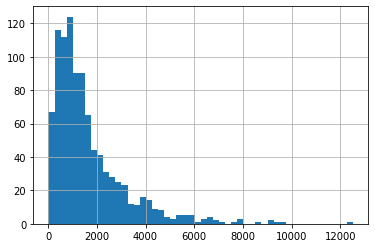

In [ ]:
df_corr_classified['laplacian'].hist(bins=50)

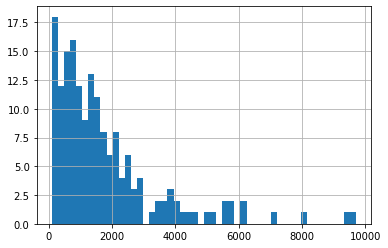

In [ ]:
df_misclassified['laplacian'].hist(bins=50)
plt.show()

Also the blurniess distributions look similar. 

If we only include values below a bluriness threshold of 100, we get the following plots.

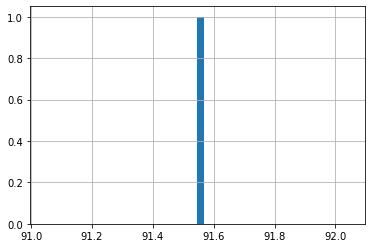

In [ ]:
df_misclassified.query('laplacian<100')['laplacian'].hist(bins=50)
plt.show()

In [ ]:
df_corr_classified.query('laplacian<100')['laplacian'].hist(bins=50)

In [ ]:
misclassified_laplacian = list(df_misclassified.query('laplacian<200')['filepath'])

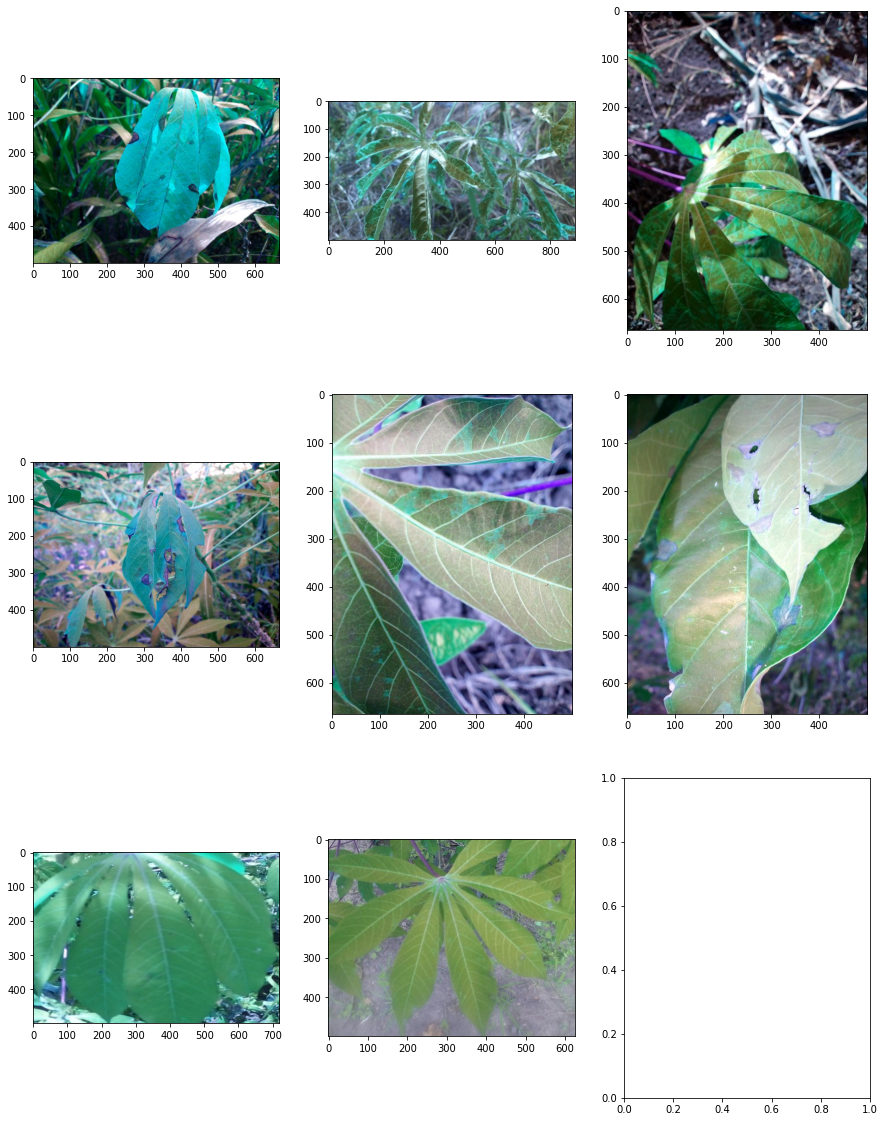

In [ ]:
def plotter(rows=3,cols=4):
  fig, ax = plt.subplots(rows,cols,figsize=[15, 20])
  ax = ax.ravel()
  for idx, img in enumerate(misclassified_laplacian):
    image = cv2.imread(img)
    ax[idx].imshow(image)
  return

Conclusion: Among the misclassified images there is not an increased number of blurred images. 

In [ ]:
figure, axes = plt.subplots(int(np.ceil(len(no_copy_wrong)/3)), 3,sharex=True, sharey=True, figsize=[15, 250], dpi=200)
axes = axes.ravel()
counter = 0    
for (name, label) in zip(wrongly_healthy_filename, wrongly_healthy_labels):
  if 'copy' in name:
    continue
  filepath = 'train/' + name
  axes[counter].text(0, -10, f"true: {name.split('/')[0]}", va ="baseline", fontsize=13, color='g', alpha=10) 
  axes[counter].text(400, -10, f"pred: {label}", va ="baseline", fontsize=13, color='r', alpha=10) 
  img = cv2.imread(filepath)
  #img = cv2.resize(img, dsize=(650,650))
  #axes[counter].axis()
  axes[counter].imshow(img)
  counter+=1
  
  
plt.show()

In [ ]:
# cbsd_misclasified_labels = [labels_dict[label] for label in wrongly_healthy2.pred_values]
# cbsd_corr_clasified_labels = [labels_dict[label] for label in correct_healthy2.pred_values]

In [ ]:
cbsd_misclasified = list(cbsd_misclasified.filename)
cbsd_corr_clasified = list(cbsd_corr_clasified.filename)

In [ ]:
cbsd_m = random.choices(cbsd_misclasified,k=100)
#cbsd_m = random.choices(cbsd_misclasified,k=100)

In [ ]:
figure, axes = plt.subplots(int(np.ceil(len(cbsd_m)/3)), 3, figsize=[15, 250], dpi=200)
axes = axes.ravel()
counter = 0    
for idx, (name, label) in enumerate(zip(cbsd_m, cbsd_pred_labels)):
  if 'copy' in name:
    continue
  
  filepath = 'train/' + name
  axes[counter].text(0, -10, f"true: {name.split('/')[0]}", va ="baseline", fontsize=20, color='g', alpha=10) 
  axes[counter].text(400, -10, f"pred: {label}", va ="baseline", fontsize=20, color='r', alpha=10) 
  img = cv2.imread(filepath)
  img = cv2.resize(img, dsize=(650,650))
  axes[counter].axis()
  axes[counter].imshow(img)
  counter+=1
  
plt.show()

In [ ]:
true_labels = [labels_dict[label] for label in err_data.true_values]
true_labels[:9]

In [ ]:
pred_labels = [labels_dict[label] for label in err_data.pred_values]
pred_labels = random.choices(pred_labels,k=100)
len(pred_labels)
pred_labels[:9]

In [ ]:
err_list = list(err_data.filename)

In [ ]:
label_list = [(x,y) for x,y in zip(true_labels,pred_labels)]

In [ ]:
err_dict ={k:v for k,v in zip(err_list,label_list)}

In [ ]:
misclassified = df.query('true_values != pred_values').filename
misclassified = list(misclassified)
misclassified=random.choices(misclassified,k=100)

In [ ]:
figure, axes = plt.subplots(int(np.ceil(len(misclassified)/3)), 3, figsize=(15, 250))
axes = axes.ravel()
    
for idx, (name, label) in enumerate(zip(misclassified, pred_labels)):
  filepath = 'train/' + name
  axes[idx].text(0, -10, f"true: {name.split('/')[0]}", va ="baseline", fontsize=20, color='g', alpha=10) 
  axes[idx].text(400, -10, f"pred: {label}", va ="baseline", fontsize=20, color='r', alpha=10) 
  img = cv2.imread(filepath)
  img = cv2.resize(img, dsize=(650,650))
  axes[idx].axis()
  axes[idx].imshow(img)
  
plt.show()

# Results and Discussions

Based on our intial hypothesis:

    - mislabeled Images
    - Leaf shape
    - Leaf color
    - Image blurriness
    - Image zoom-factor
the following systematic image analysis were made:

---
|Images|blurriness|photo_closeup|one_whole_leaf|multiple_leaves_in_image|whole_plant_in_image|yellow_taint|Shadowy_image|Mislabeled|Leaf_Backside|Off_focus|Healthy/Unhealthy_in_one_image|Weak_symptoms|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
train-cbb-11.jpg    |1	|1	|1	|0	|0	|0	|1	|0	|0	|0	|0  |0	|
train-cbb-131.jpg	  |0	|1	|1	|0	|0	|0	|1	|0	|0	|0	|0  |0	|
train-cbb-152.jpg	  |1	|0	|1	|0	|0	|0	|0	|0	|0	|0	|0  |0	|
train-cbsd-1010.jpg	|0	|1	|1	|0	|0  |0  |0  |0  |0  |0  |0  |0  |
train-cbsd-1023.jpg	|1	|1	|1	|0	|0	|0	|1	|0	|0	|0	|0  |0	|
train-cbsd-1025.jpg	|0	|0	|1	|1	|0	|0	|0	|0	|0	|1	|1  |0	|
train-cbsd-103.jpg	|0	|0	|1	|0	|0	|0	|1	|0	|0	|1	|0  |0	|
train-cbsd-1104.jpg	|0	|0	|1	|0	|0	|0	|1	|0	|1	|1	|0  |1	|
train-cbsd-1114.jpg	|0	|0	|1	|0	|0	|0	|0	|0	|0	|0	|0  |0	|
train-cbsd-1115.jpg	|0	|0	|1	|0	|0	|0	|0	|0	|0	|1	|0  |1	|
train-cbsd-1135.jpg	|0	|0	|1	|0	|0	|0	|0	|0	|0	|0	|0  |0	|
train-cbsd-1140.jpg	|0	|0	|1	|1	|0	|0	|0	|1	|0	|0	|1  |1	|
train-cbsd-1152.jpg	|1	|0	|1	|0	|0	|0	|1	|0	|0	|0	|0  |1	|
train-cbsd-1165.jpg	|0	|0	|0	|1	|0	|0	|0	|0	|0	|1	|1  |0	|
train-cbsd-1166.jpg	|1	|1	|0	|0	|0	|0	|0	|0	|0	|1	|0  |0	|
train-cbsd-118.jpg	|0	|0	|0	|1	|0	|0	|1	|0	|0	|0	|0	|0  |
train-cbsd-1194.jpg	|0	|0	|1	|0	|0	|0	|0	|1	|0	|1	|1  |1	|
train-cbsd-120.jpg	|1	|1	|0	|0	|0	|0	|0	|0	|0	|0	|0  |0	|
train-cbsd-1201.jpg	|0	|0	|0	|1	|0	|0	|0	|0	|0	|1	|0  |0	|
train-cbsd-1218.jpg	|0	|0	|1	|0	|0	|0	|1	|0	|0	|1	|0  |0	|
train-cbsd-122.jpg	|0	|0	|1	|0	|0	|1	|0	|0	|0	|0	|1  |0	|
train-cbsd-1228.jpg	|0	|0	|0	|1	|0	|0	|0	|0	|0	|1	|1  |0	|
train-cbsd-1241.jpg	|0	|0	|1	|0	|0	|0	|1	|0	|0	|1	|0  |0	|
train-cbsd-1252.jpg	|0	|0	|1	|0	|0	|0	|1	|0	|0	|1	|0  |0	|
train-cgm-120.jpg	  |0	|0	|0	|1	|0	|0	|0	|0	|0	|0	|1  |0	|
train-cgm-158.jpg	  |0	|0	|1	|0	|0	|0	|0	|0	|0	|0	|0  |0	|
train-cgm-200.jpg	  |0	|1	|0	|0	|0	|0	|1	|0	|0	|0	|0  |0	|
train-cgm-203.jpg	  |1	|0	|0	|1	|0	|0	|1	|0	|0	|0	|1  |0	|
train-cgm-22.jpg	  |0	|0	|1	|0	|0	|0	|1	|0	|0	|1	|0  |1	|
train-cgm-24.jpg	  |0	|0	|1	|0	|0	|1	|0	|0	|0	|0	|0  |1	|
train-cmd-1034.jpg	|0	|0	|0	|1	|0	|0	|0	|0	|0	|0	|1  |0	|
train-cmd-1069.jpg	|1	|1	|0	|0	|0	|0	|0	|0	|0	|1	|1  |0	|
train-cmd-1070.jpg	|1	|0	|0	|1	|0	|0	|0	|0	|0	|1	|0  |0	|
train-cmd-1161.jpg	|0	|0	|0	|1	|0	|0	|0	|0	|0	|0	|0  |0	|
train-cmd-1182.jpg	|0	|0	|0	|0	|1	|0	|0	|0	|0	|0	|1  |1	|
train-cmd-1238.jpg	|0	|0	|0	|1	|0	|0	|0	|0	|0	|0	|1  |0	|
train-cmd-1370.jpg	|1	|0	|1	|0	|0	|0	|0	|0	|0	|1	|0  |1	|
train-cmd-1425.jpg	|0	|0	|1	|0	|0	|0	|0	|0	|0	|1	|0  |0	|
train-cmd-1441.jpg	|0	|0	|1	|0	|0	|0	|0	|0	|0	|1	|0  |0	|
SUMME	              |10 |8  |24 |12 |1	|2	|13 |2  |1  |18	|12 |9  |

---

|||||Zoom-factor |Recto and verso|color|Mixed Images|Symptom intensity| 
|---|---|---|---|---|---|---|---|---|
||blurriness |Sunspots|Mislabeled|Multiple leaves|Leaf Backside|Yellow taint|Healthy/Unhealthy|weak|
|---          |---   |---   |---  |---   |---  |---  |---   |---  |
|Misclassified |10    |13    |2    |12    |1    |2    |12    |9    |  
|             |**16.4%** |**21.3%** |3.3% |**19.7%** |1.6% |3.3% |**19.7%** |**14.8%**|


From the table we can observe that **blurriness**, **Sunspots**, **Zoom-factor**, **Mixed-images** and **Sympthom intensity** on the leaf images contribute more to the misclassification. 

# Remedies:
+ taking images of leaves that more represent the class instead of taking pictures of leaves that has more features that is shared with other classes
+ taking pictures on a day light to get more resonable color contrast than taking pictures during the evening or on days where images may have different shades of RGB than in real life.
+ taking pictures with correct zooming and focus
+ apply object detection algorithms before modeling 
+ increase number of samples  